# compare TKE dissipation rate with rain

In [3]:
# preamble
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
using Rotations
using Interpolations
using DSP
using FFTW
using NCDatasets
using JLD2
using Printf

include("./read_lidar.jl")
using .read_lidar
using .read_lidar.stare
using .read_vecnav: read_vecnav_dict
import .chunks
read_stare_time  = Main.chunks.read_stare_time
read_stare_chunk = Main.chunks.read_stare_chunk
fit_offset = Main.chunks.fit_offset

include("./timing_lidar.jl")
using .timing_lidar
include("./readers.jl")
using .NoaaDas: cat_dicts
# using MAT

using PyPlot
using PyCall
using PyCall: PyObject

# PyObject method interprets Array{Union{T,Missing}} as a
# numpy masked array.
# This allows for plotting with missing values.
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

  Activating project at `~/Projects/lidar/ASTRAL2024`


PyObject

In [4]:
# helper functions 
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

m2n (generic function with 1 method)

In [16]:
# load TKE dissipation rate data
ds_e = load("epsilon_data/epsi_stare_chunks_r20250923_0934.jld")
epsi     = ds_e["epsi"]
dtime_st = ds_e["dtime_st"]
dtime_en = ds_e["dtime_en"]
height   = ds_e["height"] .+ 20 # add 20m to account for lidar Tx height

# load PSL met data
# candidate files in order of preference
files = [ "/mnt/c/Users/deszoeks/Data/EKAMSAT/PSL/netcdf/ASTRAL-nav-met-sea-flux-10min_RV-Thompson_20240428_R1_thru_20240613.nc"
          "/Users/deszoeks/Projects/ASTRAL/SSTcompare/data/PSL/ASTRAL-nav-met-sea-flux-10min_RV-Thompson_20240428_R1_thru_20240613.nc" ]
filename = files[findfirst(isfile, files)]
psl = NCDataset(filename)

Dataset: /mnt/c/Users/deszoeks/Data/EKAMSAT/PSL/netcdf/ASTRAL-nav-met-sea-flux-10min_RV-Thompson_20240428_R1_thru_20240613.nc
Group: /

Dimensions
   time = 6192

Variables
  time   (6192)
    Datatype:    Union{Missing, DateTime} (Float64)
    Dimensions:  time
    Attributes:
     units                = seconds since 2024-01-01 00:00 UTC
     standard_name        = time
     long_name            = time
     comment              = 
     method               = this time marks the beginning of the averaging interval, i.e. this time is the leading bin edge for each bin average. values provided are averages of all samples from this time step to the next time step. Only 1 good data point was required for a valid average to be computed and reported. Data were originally collected at intervals of 5 min (skin ocean temp ROSR), 1 min (radiation, temp, humidity, pressure, rain, sea water, extra met sensor), 10 Hz (wind, fast humidity, GPS, heading, pitch/roll, motion)
     coverage_content_type

In [34]:
# surface dissipation based on ustar^3

"dissipation rate at scaled height zet, using Monin-Obukhov similarity from Hartogensis and De Bruin"
function phi_epsilon(zet) 
    if !ismissing(zet)
        zet<0.1 ? 0.8 + 2.0*zet : sqrt(zet/0.1) # for stable conditions, Hartogensis and De Bruin 2005
    else
        missing
    end
end


"surface dissipation rate at height z, using Monin-Obukhov similarity from Hartogensis and De Bruin"
function sfc_epsilon(z; vonk=0.4, mo_length=psl[:mo_length][:], ustar=psl[:ustar][:])
    zet = z ./ mo_length
    phi_epsilon.(zet) .* ustar.^3 ./ (vonk.*z)
end

m2f(x) = ismissing(x) ? false : x

sfc_epsilon(5.0) # test
epsilon0 = hcat([ sfc_epsilon(z) for z in height[1:5] ]...)
zet = pd(height[1:5]) ./ psl[:mo_length][:]

6192×5 Matrix{Union{Missing, Float64}}:
   missing    missing    missing    missing    missing
   missing    missing    missing    missing    missing
   missing    missing    missing    missing    missing
   missing    missing    missing    missing    missing
   missing    missing    missing    missing    missing
 -1.38612   -2.4257    -3.46529   -4.50488   -5.54447
 -1.36776   -2.39358   -3.4194    -4.44523   -5.47105
 -1.28379   -2.24663   -3.20947   -4.1723    -5.13514
 -1.85324   -3.24317   -4.6331    -6.02303   -7.41296
 -1.70028   -2.97549   -4.2507    -5.52591   -6.80112
  ⋮                                          
   missing    missing    missing    missing    missing
   missing    missing    missing    missing    missing
   missing    missing    missing    missing    missing
   missing    missing    missing    missing    missing
   missing    missing    missing    missing    missing
   missing    missing    missing    missing    missing
   missing    missing    missing    mis

In [35]:
"compute sfc buoyancy flux in m^2 s^-3 from PSL met data"
function calc_bflx(t=psl[:tskin][:].+273.15, q=psl[:qskin][:]*1e-3)
    Cp = 1005
    L = 2.4e6
    g = 9.8
    hs = -psl[:hs_bulk] # dynamic units, now positive-up
    hl = -psl[:hl_bulk] # 
    rho = psl[:rhoair]
    # b_dyn = psl[:hb_bulk]
    wt = hs./(rho*Cp)
    wq = hl./(rho*L )
    fac = @. 1 + 0.608*q
    fac2 = 0.608 ./ fac
    # tv = @. t * fac
    bflx = @. g * ( wt/t + fac2*wq ) # m^2 s^-3
end


# WARNING PSL hb_bulk is B * (ρCpT)/g [W/m^2]
# psl[:hb_bulk][:]/3.5e4

# surface buoyancy flux
bflx0 = calc_bflx()

6192-element Vector{Union{Missing, Float64}}:
  missing
  missing
  missing
  missing
  missing
 0.0004825338595553707
 0.00046266737645200216
 0.000444845650027335
 0.00040516539287036756
 0.0004279639009641303
 ⋮
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing

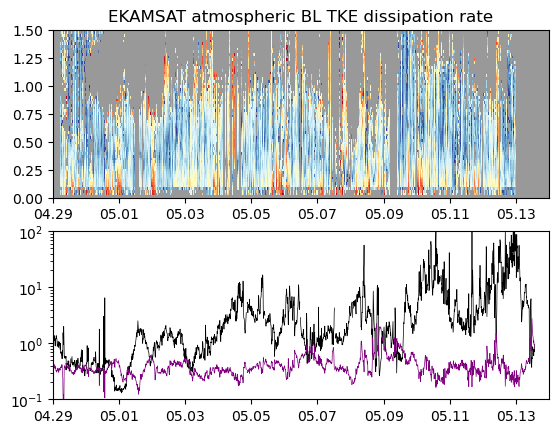

In [ ]:
# plot
epsgood(x) = (x .> 1e-6) .& (x .< 1e-1)
plotlog10(x) = epsgood(x) ? log10(x) : NaN

rainfilt(x) = (x .>= 0) .& (x .< 10) ? x : NaN

clf()
subplot(2,1,1)
pcolormesh(dtime_st, height/1e3, plotlog10.(pd(epsi)), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
# pcolormesh(psl[:time], height[1:4]/1e3, plotlog10.(pd(epsilon0[:,1:4])), vmin = -6, vmax = -1.5,
#         cmap=ColorMap("RdYlBu_r"))
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m%d"))
title("EKAMSAT atmospheric BL TKE dissipation rate")
# plot(psl[:time][:], 0.1*psl[:wspd_10][:], linewidth=0.5, color="k")
# plot(psl[:time][:], 0.1*psl[:rspd][:], linewidth=0.5, color="k")
# plot(psl[:time][:], -zet[:,1]/10, linewidth=0.5, color="k")
# plot(psl[:time][:], 1e3*bflx0, linewidth=0.5, color="purple")
xlim([DateTime(2024,4,29), DateTime(2024,5,14)])
# xlim([DateTime(2024,5,2), DateTime(2024,5,4)])
ylim([0, 1.5])
gca().set_facecolor(0.6.+[0,0,0])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))


subplot(2,1,2)
semilogy(psl[:time][:], -zet[:,1], linewidth=0.5, color="k", label="\$-z/L\$")
plot(psl[:time][:], 1e3*bflx0, linewidth=0.5, color="purple", label="\$10^3 \times B_0\$")
ylim([1e-1, 1e2])
# it's not the rain...
# semilogy(psl[:time][:], rainfilt.(psl[:prate][:]), linewidth=0.5, color="blue")
# semilogy(psl[:time][:], epsilon0[:,1], linewidth=0.5, color="k")
# semilogy(psl[:time][:], -zet[:,1], linewidth=0.5, color="r")
# plot(psl[:time][:], bflx0, linewidth=0.5, color="purple")
xlim([DateTime(2024,4,29), DateTime(2024,5,14)])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))

gcf()

In [15]:
diff(height[1:5])

4-element Vector{Float32}:
 24.0
 24.0
 24.0
 24.0

In [ ]:
# interpolate psl to lidar time
"convert datetime to Integer milliseconds, which interpolate can handle."
dt2ms(dt, dt0=DateTime(2024,4,1)) = Dates.value(Millisecond(dt - dt0))
"interpolate from psl datetime to lidar dt"
interp_psl_to_lidar(y; psldt=psl[:time][:], lidardt=start_dt) = 
    interpolate( (dt2ms.(psldt), ), y, Gridded(Linear()) )(dt2ms.(lidardt)) # returns a vector